# Predicting Duplicate Questions

The goal for this analysis is to accuractely predict if pairs of questions have the same meaning or not. This work is for the Kaggle Competition - "Quora Question Pairs": https://www.kaggle.com/c/quora-question-pairs

In [5]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import datetime, time, json
from string import punctuation

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Reshape, Merge, BatchNormalization, TimeDistributed, \
                         Lambda, Activation, LSTM, Flatten, Convolution1D, GRU, MaxPooling1D
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras import initializers
from keras import backend as K
from keras.optimizers import SGD
from collections import defaultdict

In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [7]:
train.head(6)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


In [8]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [9]:
print(train.shape)
print(test.shape)

(404290, 6)
(2345796, 3)


In [10]:
# Check for any null values
print(train.isnull().sum())
print(test.isnull().sum())

id              0
qid1            0
qid2            0
question1       0
question2       2
is_duplicate    0
dtype: int64
test_id      0
question1    2
question2    4
dtype: int64


In [11]:
# Add the string 'empty' to empty strings
train = train.fillna('empty')
test = test.fillna('empty')

In [12]:
print(train.isnull().sum())
print(test.isnull().sum())

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64
test_id      0
question1    0
question2    0
dtype: int64


In [13]:
# Preview some of the pairs of questions
for i in range(6):
    print(train.question1[i])
    print(train.question2[i])
    print()

What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

How can I increase the speed of my internet connection while using a VPN?
How can Internet speed be increased by hacking through DNS?

Why am I mentally very lonely? How can I solve it?
Find the remainder when [math]23^{24}[/math] is divided by 24,23?

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
Which fish would survive in salt water?

Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?



In [191]:
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r":", " ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r"usa", "America", text)
    text = re.sub(r"canada", "Canada", text)
    text = re.sub(r"japan", "Japan", text)
    text = re.sub(r"germany", "Germany", text)
    text = re.sub(r"burma", "Burma", text)
    text = re.sub(r"rohingya", "Rohingya", text)
    text = re.sub(r"zealand", "Zealand", text)
    text = re.sub(r"cambodia", "Cambodia", text)
    text = re.sub(r"zealand", "Zealand", text)
    text = re.sub(r"norway", "Norway", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r"pakistan", "Pakistan", text)
    text = re.sub(r"britain", "Britain", text)
    text = re.sub(r"switzerland", "Switzerland", text)
    text = re.sub(r"china", "China", text)
    text = re.sub(r"chinese", "Chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iphone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    text = ''.join([c for c in text if c not in punctuation])
    
    # Return a list of words
    return(text)

In [192]:
def process_questions(question_list, questions, question_list_name, dataframe):
    '''transform questions and display progress'''
    for question in questions:
        question_list.append(text_to_wordlist(question))
        if len(question_list) % 100000 == 0:
            progress = len(question_list)/len(dataframe) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

In [193]:
train_question1 = []
process_questions(train_question1, train.question1, 'train_question1', train)

train_question1 is 24.7% complete.
train_question1 is 49.5% complete.
train_question1 is 74.2% complete.
train_question1 is 98.9% complete.


In [194]:
train_question2 = []
process_questions(train_question2, train.question2, 'train_question2', train)

train_question2 is 24.7% complete.
train_question2 is 49.5% complete.
train_question2 is 74.2% complete.
train_question2 is 98.9% complete.


In [165]:
test_question1 = []
process_questions(test_question1, test.question1, 'test_question1', test)

test_question1 is 4.3% complete.
test_question1 is 8.5% complete.
test_question1 is 12.8% complete.
test_question1 is 17.1% complete.
test_question1 is 21.3% complete.
test_question1 is 25.6% complete.
test_question1 is 29.8% complete.
test_question1 is 34.1% complete.
test_question1 is 38.4% complete.
test_question1 is 42.6% complete.
test_question1 is 46.9% complete.
test_question1 is 51.2% complete.
test_question1 is 55.4% complete.
test_question1 is 59.7% complete.
test_question1 is 63.9% complete.
test_question1 is 68.2% complete.
test_question1 is 72.5% complete.
test_question1 is 76.7% complete.
test_question1 is 81.0% complete.
test_question1 is 85.3% complete.
test_question1 is 89.5% complete.
test_question1 is 93.8% complete.
test_question1 is 98.0% complete.


In [166]:
test_question2 = []
process_questions(test_question2, test.question2, 'test_question2', test)

test_question2 is 4.3% complete.
test_question2 is 8.5% complete.
test_question2 is 12.8% complete.
test_question2 is 17.1% complete.
test_question2 is 21.3% complete.
test_question2 is 25.6% complete.
test_question2 is 29.8% complete.
test_question2 is 34.1% complete.
test_question2 is 38.4% complete.
test_question2 is 42.6% complete.
test_question2 is 46.9% complete.
test_question2 is 51.2% complete.
test_question2 is 55.4% complete.
test_question2 is 59.7% complete.
test_question2 is 63.9% complete.
test_question2 is 68.2% complete.
test_question2 is 72.5% complete.
test_question2 is 76.7% complete.
test_question2 is 81.0% complete.
test_question2 is 85.3% complete.
test_question2 is 89.5% complete.
test_question2 is 93.8% complete.
test_question2 is 98.0% complete.


In [195]:
# Preview some transformed pairs of questions
i = 0
for i in range(i,i+10):
    print(train_question1[i])
    print(train_question2[i])
    print()

what is the step by step guide to invest in share market in India 
what is the step by step guide to invest in share market 

what is the story of kohinoor koh i noor diamond 
what would happen if the Indian government stole the kohinoor koh i noor diamond back 

how can i increase the speed of my internet connection while using a vpn 
how can internet speed be increased by hacking through dns 

why am i mentally very lonely how can i solve it 
find the remainder when math 23 24 math is divided by 24 23 

which one dissolve in water quickly sugar salt methane and carbon di oxide 
which fish would survive in salt water 

astrology i am a capricorn sun cap moon and cap rising what does that say about me 
i am a triple capricorn sun moon and ascendant in capricorn what does this say about me 

should i buy tiago 
what keeps childern active and far from phone and video games 

how can i be a good geologist 
what should i do to be a great geologist 

when do you use instead of 
when do you 

In [167]:
# Count the number of unique tokens in the questions
token_count = defaultdict(int)

for question in train_question1:
    token_count[question] += 1
print("train_question1 is complete.")
    
for question in train_question2:
    token_count[question] += 1
print("train_question2 is complete")

for question in test_question1:
    token_count[question] += 1
print("test_question1 is complete.")

for question in test_question2:
    token_count[question] += 1
print("test_question2 is complete")

print("Total number of unique tokens:", len(token_count))

train_question1 is complete.
train_question2 is complete
test_question1 is complete.
test_question2 is complete
Total number of unique tokens: 4783127


In [168]:
# Find the length of questions
lengths = []
for question in train_question1:
    lengths.append(len(question.split()))

for question in train_question2:
    lengths.append(len(question.split()))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [169]:
lengths.counts.describe()

count    808580.000000
mean         11.259242
std           6.077335
min           0.000000
25%           7.000000
50%          10.000000
75%          13.000000
max         244.000000
Name: counts, dtype: float64

In [170]:
print(np.percentile(lengths.counts, 99.0))
print(np.percentile(lengths.counts, 99.4))
print(np.percentile(lengths.counts, 99.5))
print(np.percentile(lengths.counts, 99.9))

32.0
35.0
37.0
53.0


In [171]:
# tokenize the 200,000 most common words for all of the questions
num_words = 200000

all_questions = train_question1 + train_question2 + test_question1 + test_question2
tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(all_questions)
print("Fitting is complete.")
train_question1_word_sequences = tokenizer.texts_to_sequences(train_question1)
print("train_question1 is complete.")
train_question2_word_sequences = tokenizer.texts_to_sequences(train_question2)
print("train_question2 is complete")

Fitting is complete.
train_question1 is complete.
train_question2 is complete.


In [172]:
test_question1_word_sequences = tokenizer.texts_to_sequences(test_question1)
print("test_question1 is complete.")
test_question2_word_sequences = tokenizer.texts_to_sequences(test_question2)
print("test_question2 is complete.")

test_question1 is complete.
test_question2 is complete.


In [173]:
word_index = tokenizer.word_index
print("Words in index: %d" % len(word_index))

Words in index: 120588


In [174]:
# Pad the questions so that they all have the same length.

max_question_len = 36

train_q1 = pad_sequences(train_question1_word_sequences,
                              maxlen = max_question_len,
                              padding = 'post',
                              truncating = 'post')
print("train_q1 is complete.")

train_q2 = pad_sequences(train_question2_word_sequences,
                              maxlen = max_question_len,
                              padding = 'post',
                              truncating = 'post')
print("train_q2 is complete.")

train_q1 is complete.
train_q2 is complete.


In [175]:
test_q1 = pad_sequences(test_question1_word_sequences,
                             maxlen = max_question_len,
                             padding = 'post',
                             truncating = 'post')
print("test_q1 is complete.")

test_q2 = pad_sequences(test_question2_word_sequences,
                             maxlen = max_question_len,
                             padding = 'post',
                             truncating = 'post')
print("test_q2 is complete.")

test_q1 is complete.
test_q2 is complete.


In [30]:
y_train = train.is_duplicate

In [31]:
# Load GloVe to use pretrained vectors
# From this link: https://nlp.stanford.edu/projects/glove/
embeddings_index = {}
with open('glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 151250


In [176]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = len(word_index)
word_embedding_matrix = np.zeros((nb_words + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        word_embedding_matrix[i] = embedding_vector

print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))

Null word embeddings: 75386


In [177]:
units = 128 # Number of nodes in the Dense layers
dropout = 0.25 # Percentage of nodes to drop
nb_filter = 32 # Number of filters to use in Convolution1D
filter_length = 3 # Length of filter for Convolution1D

# Initialize weights and biases for the Dense layers
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=2)
bias = bias_initializer='zeros'

model1 = Sequential()
model1.add(Embedding(nb_words + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = max_question_len,
                     trainable = False))

model1.add(Convolution1D(filters = nb_filter, 
                         kernel_size = filter_length, 
                         padding = 'same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(dropout))

model1.add(Convolution1D(filters = nb_filter, 
                         kernel_size = filter_length, 
                         padding = 'same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Dropout(dropout))

model1.add(Flatten())



model2 = Sequential()
model2.add(Embedding(nb_words + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = max_question_len,
                     trainable = False))

model2.add(Convolution1D(filters = nb_filter, 
                         kernel_size = filter_length, 
                         padding = 'same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(dropout))

model2.add(Convolution1D(filters = nb_filter, 
                         kernel_size = filter_length, 
                         padding = 'same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(dropout))

model2.add(Flatten())



model3 = Sequential()
model3.add(Embedding(nb_words + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = max_question_len,
                     trainable = False))
model3.add(TimeDistributed(Dense(embedding_dim)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(dropout))
model3.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(embedding_dim, )))



model4 = Sequential()
model4.add(Embedding(nb_words + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = max_question_len,
                     trainable = False))

model4.add(TimeDistributed(Dense(embedding_dim)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(dropout))
model4.add(Lambda(lambda x: K.max(x, axis=1), output_shape=(embedding_dim, )))




modela = Sequential()
modela.add(Merge([model1, model2], mode='concat'))
modela.add(Dense(units*2, kernel_initializer=weights, bias_initializer=bias))
modela.add(BatchNormalization())
modela.add(Activation('relu'))
modela.add(Dropout(dropout))

modela.add(Dense(units, kernel_initializer=weights, bias_initializer=bias))
modela.add(BatchNormalization())
modela.add(Activation('relu'))
modela.add(Dropout(dropout))

modelb = Sequential()
modelb.add(Merge([model3, model4], mode='concat'))
modelb.add(Dense(units*2, kernel_initializer=weights, bias_initializer=bias))
modelb.add(BatchNormalization())
modelb.add(Activation('relu'))
modelb.add(Dropout(dropout))

modelb.add(Dense(units, kernel_initializer=weights, bias_initializer=bias))
modelb.add(BatchNormalization())
modelb.add(Activation('relu'))
modelb.add(Dropout(dropout))



model = Sequential()
model.add(Merge([modela, modelb], mode='concat'))
model.add(Dense(units*2, kernel_initializer=weights, bias_initializer=bias))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(units, kernel_initializer=weights, bias_initializer=bias))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(units, kernel_initializer=weights, bias_initializer=bias))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(1, kernel_initializer=weights, bias_initializer=bias))
model.add(BatchNormalization())
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:90: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:102: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:116: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [178]:
# save the best weights for predicting the test question pairs
save_best_weights = 'question_pairs_weights.h5'

t0 = time.time()
callbacks = [ModelCheckpoint(save_best_weights, monitor='val_loss', save_best_only=True),
             EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')]
history = model.fit([train_q1, train_q2, train_q1, train_q2],
                    y_train,
                    batch_size=256,
                    epochs=100,
                    validation_split=0.15,
                    verbose=True,
                    shuffle=True,
                    callbacks=callbacks)
t1 = time.time()
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Train on 343646 samples, validate on 60644 samples
Epoch 1/100
343646/343646 [==============================] - 1805s - loss: 0.5381 - acc: 0.7265 - val_loss: 0.4960 - val_acc: 0.7489
Epoch 2/100
343646/343646 [==============================] - 1639s - loss: 0.4645 - acc: 0.7724 - val_loss: 0.4445 - val_acc: 0.7851
Epoch 3/100
343646/343646 [==============================] - 1580s - loss: 0.4351 - acc: 0.7889 - val_loss: 0.4259 - val_acc: 0.7931
Epoch 4/100
343646/343646 [==============================] - 1582s - loss: 0.4147 - acc: 0.8007 - val_loss: 0.4236 - val_acc: 0.7914
Epoch 5/100
343646/343646 [==============================] - 1589s - loss: 0.4001 - acc: 0.8102 - val_loss: 0.4056 - val_acc: 0.8048
Epoch 6/100
343646/343646 [==============================] - 1593s - loss: 0.3864 - acc: 0.8177 - val_loss: 0.3878 - val_acc: 0.8143
Epoch 7/100
343646/343646 [==============================] - 1600s - loss: 0.3751 - acc: 0.8247 - val_loss: 0.4020 - val_acc: 0.8047
Epoch 8/100
343646

In [179]:
# Aggregate the summary statistics
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                              'train_acc': history.history['acc'],
                              'valid_acc': history.history['val_acc'],
                              'train_loss': history.history['loss'],
                              'valid_loss': history.history['val_loss']})

In [180]:
summary_stats

,epoch,train_acc,train_loss,valid_acc,valid_loss
0,1,0.726515,0.538137,0.748912,0.495959
1,2,0.772367,0.464475,0.785140,0.444471
2,3,0.788908,0.435145,0.793121,0.425925
3,4,0.800658,0.414688,0.791373,0.423571
4,5,0.810215,0.400064,0.804795,0.405567
5,6,0.817748,0.386420,0.814260,0.387757
6,7,0.824686,0.375122,0.804713,0.402002
7,8,0.831082,0.363883,0.808918,0.393636
8,9,0.836221,0.354138,0.812776,0.391497
9,10,0.840120,0.347141,0.822357,0.376932


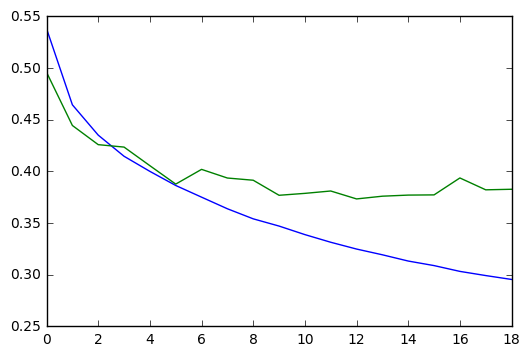

In [181]:
plt.plot(summary_stats.train_loss) # blue
plt.plot(summary_stats.valid_loss) # green
plt.show()

In [182]:
# Find the minimum validation loss during the training
min_loss, idx = min((loss, idx) for (idx, loss) in enumerate(history.history['val_loss']))
print('Minimum loss at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(min_loss))
min_loss = round(min_loss, 4)

Minimum loss at epoch 13 = 0.3734


In [183]:
# Make predictions with the best weights
model.load_weights(save_best_weights)
predictions = model.predict([test_q1, test_q2, test_q1, test_q2], verbose = True)

2345792/2345796 [============================>.] - ETA: 0s

In [184]:
#Create submission
submission = pd.DataFrame(predictions, columns=['is_duplicate'])
submission.insert(0, 'test_id', test.test_id)
file_name = 'submission_{}.csv'.format(min_loss)
submission.to_csv(file_name, index=False)

In [185]:
submission.head(10)

,test_id,is_duplicate
0,0,0.054217
1,1,0.093852
2,2,0.817997
3,3,0.087583
4,4,0.496896
5,5,0.019695
6,6,0.902416
7,7,0.959842
8,8,0.918632
9,9,0.205630


# Summary

I am still trying to improve this model, and for the most part, it is going rather well. Currently, I am ranked in the top 14% of the competition. A few different strategies that I still want to test out:
- Improving how I clean the text. I have yet to find a fast and accurate function that I can import to do this.
- Initializing the weights and biases differently. I have read that using truncated normal can be effective, but I want to try using different standard deviations.
- Although I have already tried many different architectures, I will keep reading about this subject and see what useful information I can find and implement.